In [1]:
!pip install nbimporter
import numpy as np
import copy
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import math
import scipy.linalg
import scipy.special

In [2]:
#import required functions from external file
#import nbimporter
#import import_ipynb
#import solver.ipynb 
#import ipynb.fs.defs.sparseGrids 
#import ipynb.fs.defs.stochasticGalerkin

In [3]:
# define global variables
problem = "nonsmooth"

In [4]:
# deterministic solver files

# numerical flux function approximates solution at cell interfaces
def g(u,v,lamda,y):
    return 0.5*(f(u,y)+f(v,y)-lamda*(v-u)) # Lax-Friedrichs flux

def ComputeSolution(y,Nx=100,tEnd=0.5,a=0.0,b=2*np.pi):
    
    # define spatial domain [a,b]
    x = np.linspace(a,b,Nx-2) # vector of cell midpoints
    dx = x[1]-x[0]
    x = np.hstack((x[0]-dx,x,x[-1]+dx)) # add ghost cells
    
    # setup initial condition
    u = np.zeros((Nx,))
    for j in range(Nx):
        u[j] = ICScalar(x[j],y)
    
    # return solution if velocity is near zero
    if np.abs(y) < 1e-15 or tEnd < 1e-15:
        return u
    
    cMax = y
    dt = dx/np.absolute(cMax) # determine time step size with CFL condition

    uNew = copy.deepcopy(u)


    # time loop
    t = 0.0
    while t < (tEnd-dt):
        # time update solution
        for j in range(1,(Nx-1)):
            uNew[j] = u[j] - dt/dx*(g(u[j],u[j+1],dx/dt,y)-g(u[j-1],u[j],dx/dt,y))
            
        # apply boundary condition
        if problem == "nonsmooth":
            uNew[-1] = uExactScalar(t,b,y)
            uNew[0] = uExactScalar(t,a,y)
        else:
            uNew[-1] = uNew[2]
            uNew[0] = uNew[-1-1]
            
        u = copy.deepcopy(uNew)
        t = t + dt

    # perform final time step
    dt = tEnd - t
    for j in range(1,(Nx-1)):
        uNew[j] = u[j] - dt/dx*(g(u[j],u[j+1],dx/dt,y)-g(u[j-1],u[j],dx/dt,y))
    return uNew



In [117]:
def applyQuadrature (f, q, w):
  if len(q.shape)==1:
    q=np.expand_dims(q,axis=0)
    
  dim = np.size(q,0)

  if dim == 1:
    integral=np.sum(np.multiply(f(q),w))
  elif dim == 2:
    integral = np.sum(np.multiply(f(q[0,:],q[1,:]),w))
  elif dim == 3:
    integral = np.sum(np.multiply(f(q[0,:],q[1,:],q[2,:]),w))
  else:
    raise ValueError("Functions not yet implemented for {0} dimensions".format(dim))

  return integral

def tensorizePointSet(x,y):
  #x is vector or (nxm) matrix, y is vector
  #returns matrix containing x_i yj for all i,j combinations
  s = x.shape
  if len(s)==1:
    x=np.expand_dims(x,axis=0)
    s = x.shape
  n = s[0]
  m = s[1]
  z=np.empty((n+1,m*np.size(y)))
  k=0
  for i in range(m):
    for j in range(np.size(y)):
      if n==1:
        z[:,k]=np.squeeze(np.vstack((x[:,i],y[j])))
        k=k+1
      else:
        z[:,k]=np.squeeze(np.hstack((x[:,i],y[j])))
        k=k+1
  
  return z

def tensorizeWeightSet (x,y):
  #x,y are vectors
  #returns matrix z of weights, containing x_i,y_j for all combinations of i,j
  z=np.empty((1,np.size(x)*np.size(y)))

  if len(x.shape)==1:
    x=np.expand_dims(x,axis=0)
  if len(y.shape)==1:
    y=np.expand_dims(y,axis=0)

  k=0
  for i in range(np.size(x)):
    for j in range(np.size(y)):
      #z = np.hstack((z, x[:,i]*y[:,j]))
      z[:,k]=x[:,i]*y[:,j]
      k = k+1
  return z 

#Implement quadrature rules

#trapezoidal
def trap(l):
  if l == 0:
    q=0.5
    w=0
  else:
    n = 2**(l-1)+1
    dx = 1/(n-1)
    q = np.arange(n)*dx

    if n == 2:
      tmp = 1
    else:
      tmp = 2/(n-2)*2/2

    w = 2*np.ones((1,n))*tmp
    w[:,0] = tmp
    w[:,np.size(w)-1] = tmp
    w = 2/np.sum(w)*w
    w = w/np.sum(w)

  return q,w

#Clenshaw-Curtis
def cc(l):
  if l == 0:
    q = 0.5
    w = 0
  
  else:
    q = 1/2* (1-np.cos((math.pi*np.arange(1,2**(l-1)+2) - math.pi)/2**(l-1)))
    n = np.size(q)-1
    def b(j):
      return 1 * (j==n/2) + 2 * (j<n/2)
    
    def c(k):
      return 1* (k%n==0) + 2 * (k%n!=0)
    
    w = np.zeros((1,n+1))

    for k in range(n+1):
      tmp = 0
      for j in range(1,math.floor(n/2)+1):
        tmp = tmp + b(j)/(4*j**2-1)*np.cos(2*j*(k*math.pi/n))
      w[:,k] = c(k)/n*(1-tmp)

    w = w/np.sum(w)

  return q,w

def fejer(l):
    n = 2**(l-1)
    degree = n

    points = -np.cos((np.pi * np.arange(1, n + 1)) / (n + 1))

    n += 1
    N = np.arange(1, n, 2)
    length = len(N)
    m = n - length
    v0 = np.concatenate(
        [2.0 / N / (N - 2), np.array([1.0 / N[-1]]), np.zeros(m)]
    )
    v2 = -v0[:-1] - v0[:0:-1]

    w = np.fft.ihfft(v2)
    assert max(w.imag) < 1.0e-15
    w = w.real

    if n % 2 == 1:
        weights = np.concatenate([w, w[::-1]])
    else:
        weights = np.concatenate([w, w[len(w) - 2 :: -1]])

    # cut off first and last
    weights = weights[1:-1]
    weights = np.expand_dims(weights,axis=0)
    
    return points,weights
    
    
#Return all points of sparse quadrature 
def getAllNodesWeights(dim, l, sparseflag):
  if l == 0:
    q = np.ones((dim,1))
    w = 0
  
  else:
    #1D
    if dim == 1:
      q,w = quadrule(l)
    elif dim == 2:
      q=np.empty((2,1))
      w=np.empty((1,1))
      for i in range(1,l+dim):
        for j in range(1,l+dim):
          if sparseflag:
            if i+j<=l+dim-1:
              qi, wi = quadrule(i)
              if i>1:
                qi_low, wi_low = quadrule(i-1)
                wi[:,0::2] = wi[:,0::2] - wi_low
              qj, wj = quadrule(j)
              if j>1:
                qj_low, wj_low = quadrule(j-1)
                wj[:,0::2] = wj[:,0::2] - wj_low
            
              qij = tensorizePointSet(qi,qj)
              wij = tensorizeWeightSet(wi,wj)
              q = np.hstack((q,qij))
              w = np.hstack((w,wij))
          else:
            if max(i,j)<=l:
              qi, wi = quadrule(i)
              if i>1:
                qi_low, wi_low = quadrule(i-1)
                wi[:,0::2] = wi[:,0::2] - wi_low
              qj, wj = quadrule(j)
              if j>1:
                qj_low, wj_low = quadrule(j-1)
                wj[:,0::2] = wj[:,0::2] - wj_low
              qij = tensorizePointSet(qi,qj)
              wij = tensorizeWeightSet(wi,wj)
              q = np.hstack((q,qij))
              w = np.hstack((w,wij))
  
      q = np.delete(q,0,1)
      w = np.delete(w,0,None)

    elif dim == 3:
        q=np.empty((3,1))
        w=np.empty((1,1))
        for i in range(1,dim+l):
          for j in range(1,dim+l):
            for k in range(1,dim+l):
              if sparseflag:
                if i+j+k <=l+dim-1:
                  qi,wi = quadrule(i)
                  if i>1:
                    qi_low, wi_low = quadrule(i-1)
                    wi[:,0::2] = wi[:,0::2] - wi_low
                  qj, wj = quadrule(j)
                  if j>1:
                    qj_low, wj_low = quadrule(j-1)
                    wj[:,0::2] = wj[:,0::2] - wj_low
                  qk, wk = quadrule(k)
                  if k>1:
                    qk_low, wk_low = quadrule(k-1)
                    wk[:,0::2] = wk[:,0::2] - wk_low
                  qij = tensorizePointSet(qi,qj)
                  wij = tensorizeWeightSet(wi,wj)
                  qijk = tensorizePointSet(qij,qk)
                  wijk = tensorizeWeightSet(wij,wk)
                  q = np.hstack((q,qijk))
                  w = np.hstack((w,wijk))
              else:
                if max([i,j,k])<=l:
                  qi,wi = quadrule(i)
                  if i>1:
                    qi_low, wi_low = quadrule(i-1)
                    wi[:,0::2] = wi[:,0::2] - wi_low
                  qj, wj = quadrule(j)
                  if j>1:
                    qj_low, wj_low = quadrule(j-1)
                    wj[:,0::2] = wj[:,0::2] - wj_low
                  qk, wk = quadrule(k)
                  if k>1:
                    qk_low, wk_low = quadrule(k-1)
                    wk[:,0::2] = wk[:,0::2] - wk_low
                  qij = tensorizePointSet(qi,qj)
                  wij = tensorizeWeightSet(wi,wj)
                  qijk = tensorizePointSet(qij,qk)
                  wijk = tensorizeWeightSet(wij,wk)
                  q = np.hstack((q,qijk))
                  w = np.hstack((w,wijk))
        q = np.delete(q,0,1)
        w = np.delete(w,0,None)
    else:
        raise ValueError("Higher dimensions than 3D not yet implemented")

  w = w/np.sum(w)
  return q,w


def sparsegrid(d,l,f):
    dim = d
    if f=='trap':
        q,w = trap(l)
    elif f=='cc':
        q,w = cc(l)
    elif f=='fejer':
        q,w =fejer(l)
        print('Warning: Implementation of Fejer nodes might contain errors!')
    else:
        raise ValueError('Please enter a valid function identifier (trap/cc/fejer)!')
    return q,w

In [7]:
# files for SG implementation

# numerical flux SG system
def G(u,v,A,AbsA):
    return 0.5*(np.dot(A,(u+v))-np.dot(AbsA,(v-u)))

def mylegendre(n,X):
    #collects Legendre polynomials up to degree n evaluated at X
  res = []
  for m in range(n+1):
    res.append(scipy.special.lpmv(m,n,X))
  res =np.array(res)
  if res.ndim==1:
    res=np.expand_dims(res,axis=1)
  return res[0,:]

def StochasticGalerkin(N=5,Nx=100,tEnd=0.5,a=0.0,b=2*np.pi):
    # define spatial domain [a,b]
    x = np.linspace(a,b,Nx-2) # vector of cell midpoints
    dx = x[1]-x[0]
    
    x = np.hstack((x[0]-dx,x,x[-1]+dx)) # add ghost cells
    cfl = 1.0

    # precompute Legendre basis functions at quadrature points
    Nq = 2*N+1
    y,w = np.polynomial.legendre.leggauss(Nq)
    #w=w/sum(w)
    PhiQuad = np.zeros((N,Nq))
    PhiQuadW = np.zeros((N,Nq))
    for i in range(N):
        for k in range(Nq):
            n = i
            PhiQuad[i,k] = np.sqrt(2.0*n+1.0)*mylegendre(n,y[k])
            PhiQuadW[i,k] = PhiQuad[i,k]*w[k]*0.5

    # compute flux Jacobian
    A = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            for k in range(Nq):
                A[i,j] = A[i,j] + w[k]*PhiQuad[i,k]*PhiQuad[j,k]*c(y[k])*0.5
    
    
    # compute Roe Matrix
    ev, T = np.linalg.eig(A)
    D = np.absolute(np.diag(ev))
    AbsA = np.linalg.multi_dot((T,D,np.linalg.inv(T)))
    
    dt = cfl*dx/np.max(D) # determine time step size with CFL condition

    # setup initial condition
    u = np.zeros((Nx,N))
    for j in range(Nx):
        for i in range(N):
            u[j,:] = np.dot(PhiQuadW,IC(x[j],y))
    uNew = copy.deepcopy(u)

    # time loop
    t = 0.0
    while t < (tEnd-dt):
        #println(t)
        # time update solution
        for j in range(1,(Nx-1)):
            uNew[j,:] = u[j,:] - dt/dx*(G(u[j,:],u[j+1,:],A,AbsA)-G(u[j-1,:],u[j,:],A,AbsA))
        
        # apply boundary condition
        if problem == "nonsmooth":
            uNew[-1,:] = np.dot(PhiQuadW,uExact(t,b,y))
            uNew[0,:] = np.dot(PhiQuadW,uExact(t,a,y))
        else:
            uNew[-1,:] = uNew[2,:]
            uNew[0,:] = uNew[-1-2,:]
            
        u = copy.deepcopy(uNew)
        t = t + dt

    # perform final time step
    dt = tEnd-t
    for j in range(1,(Nx-1)):
        uNew[j,:] = u[j,:] - dt/dx*(G(u[j,:],u[j+1,:],A,AbsA)-G(u[j-1,:],u[j,:],A,AbsA))
    return uNew


Level: 2  L2-Error: 0.007732105179927176


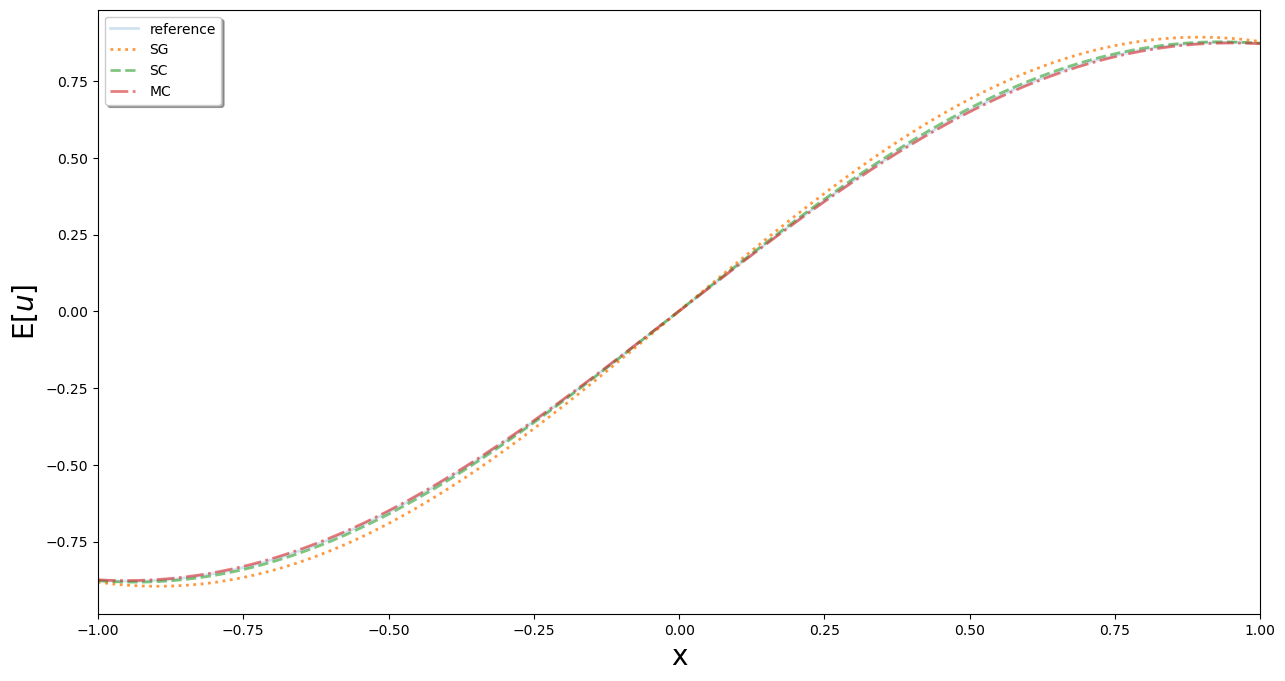

In [8]:
### Some smaller functions for general problem ###

# exact solution
def uExactScalar(t,x,y):
    if problem == "nonsmooth":
        kappa = 1.0
        if y > 0:
            return np.sin(kappa*(x-c(y)*t))
        else:
            return np.sin(2*kappa*(x-c(y)*t))
    else:
        return np.cos(x-t*y)

# exact solution
def uExact(t,x,y):
    Nq = y.size
    out = np.zeros((Nq,))
    for k in range(Nq):
        if problem == "nonsmooth":
            kappa = 1.0
            if y[k] > 0:
                out[k] = np.sin(kappa*(x-c(y[k])*t))
            else:
                out[k] = np.sin(2*kappa*(x-c(y[k])*t))
        else:
            out[k] = np.cos(x-t*y[k])
    return out

# exact expected value
def uExpExact(t,x):
    return (-np.sin(x-t)/t+np.sin(x+t)/t) * 0.5

# wave speed function
def c(y):
    if problem == "nonsmooth":
        sigma = 0.5
    else:
        sigma = 1.0
    return sigma*y

# physical flux function
def f(u,y):
    return c(y)*u

# initial condition
def ICScalar(x,y=0.0):
    if problem == "nonsmooth":
        kappa = 1.0
        if y > 0:
            return np.sin(kappa*x)
        else:
            return np.sin(2*kappa*x)
    else:
        return np.cos(x)
    
# initial condition
def IC(x,y=0.0):
    Nq = y.size
    out = np.zeros((Nq,))
    for k in range(Nq):
        if problem == "nonsmooth":
            kappa = 1.0
            if y[k] > 0:
                out[k] = np.sin(kappa*x)
            else:
                out[k] = np.sin(2*kappa*x)
        else:
            out[k] = np.cos(x)
    return out

# boundary condition left
def BCLeft(t,y):
    kappa = 1.0
    Nq = y.size
    out = np.zeros((Nq,))
    for k in range(Nq):
        if y[k] > 0:
            out[k] = np.sin(kappa*(-1.0-c(y[k])*t))
        else:
            out[k] = np.sin(2*kappa*(-1.0-c(y[k])*t))
    return out
        

# boundary condition right
def BCRight(t,y):
    kappa = 1.0
    Nq = y.size
    out = np.zeros((Nq,))
    for k in range(Nq):
        if y[k] > 0:
            out[k] = np.sin(kappa*(1.0-c(y[k])*t))
        else:
            out[k] = np.sin(2*kappa*(1.0-c(y[k])*t))
    return out

#####################################################

# number of uncertain dimensions
dim = 1

# level of sparse/tensorized grid 
level = 2

# number of spatial cells
Nx = 1000

# spatial domain ranges
if problem == "nonsmooth":
    a = -1.0
    b = 1.0
else:
    a = 0.0
    b = 2*np.pi

# end time
tEnd = 0.01

x = np.linspace(a,b,Nx);

###### Stochastic Galerkin ######
# number of moments
N = 4
uSG = StochasticGalerkin(N,Nx,tEnd,a,b)

###### Collocation Sparse Grids ######
#nodes, weights = sparsegrid(dim, level,'cc')   # using gausshermite as 1D rule
nodes, weights = np.polynomial.hermite.hermgauss(level)
weights=weights/sum(weights)
Nq = weights.size
uSC = np.zeros((Nx,))
for k in range(Nq):
    vals = ComputeSolution(nodes[k],Nx,tEnd,a,b)
    uSC = uSC + weights[k]*vals


###### Monte-Carlo ######
NMC = 1000
uMC = np.zeros((Nx,))
for k in range(NMC):
    y = 2*np.random.rand()-1
    vals = ComputeSolution(y,Nx,tEnd,a,b)
    uMC = uMC + (1/NMC)*vals
    

###### Monte-Carlo Reference solution ######
NMCRef = 5000
uRef = np.zeros((Nx,))
vals = np.zeros((Nx,))
for k in range(NMCRef):
    y = 2*np.random.rand()-1
    for j in range(Nx):
        vals[j] = uExactScalar(tEnd,x[j],y)
    uRef = uRef + (1/NMCRef)*vals
    
def L2Error(u,uRef,x):
    Nx = x.size
    dx = x[1]-x[0];
    tmp = 0
    for j in range(1,(Nx-1)):
        tmp = tmp + dx*(u[j] - uRef[j])**2
    return np.sqrt(tmp)

print("Level: {0}  L2-Error: {1}".format(level,L2Error(uSC,uRef,x)))

###### plotting ######
plt.figure(figsize=(15, 8), dpi=100)
plt.plot(np.linspace(a,b,Nx),uRef, linewidth=2, label="reference", alpha=0.2)
plt.plot(np.linspace(a,b,Nx),uSG[:,0], linestyle='dotted', linewidth=2, label="SG", alpha=0.8)
plt.plot(np.linspace(a,b,Nx),uSC, linestyle='dashed', linewidth=2, label="SC", alpha=0.6)
plt.plot(np.linspace(a,b,Nx),uMC, linestyle='dashdot', linewidth=2, label="MC", alpha=0.6)
plt.xlim([a,b])
plt.xlabel("x", fontsize=20)
plt.ylabel("E$[u]$", fontsize=20)
_=plt.legend(shadow=True, fancybox=True)

#print("ref = ",uRef)

## Convergence

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in double_scalars


1  0.2455282004318577
2  0.11396717679626865
3  0.1149730544765736
4  0.08642624445790435
5  0.08741538433830173
6  0.0731103225250991
7  0.07360121851506853
8  0.06454580379476244


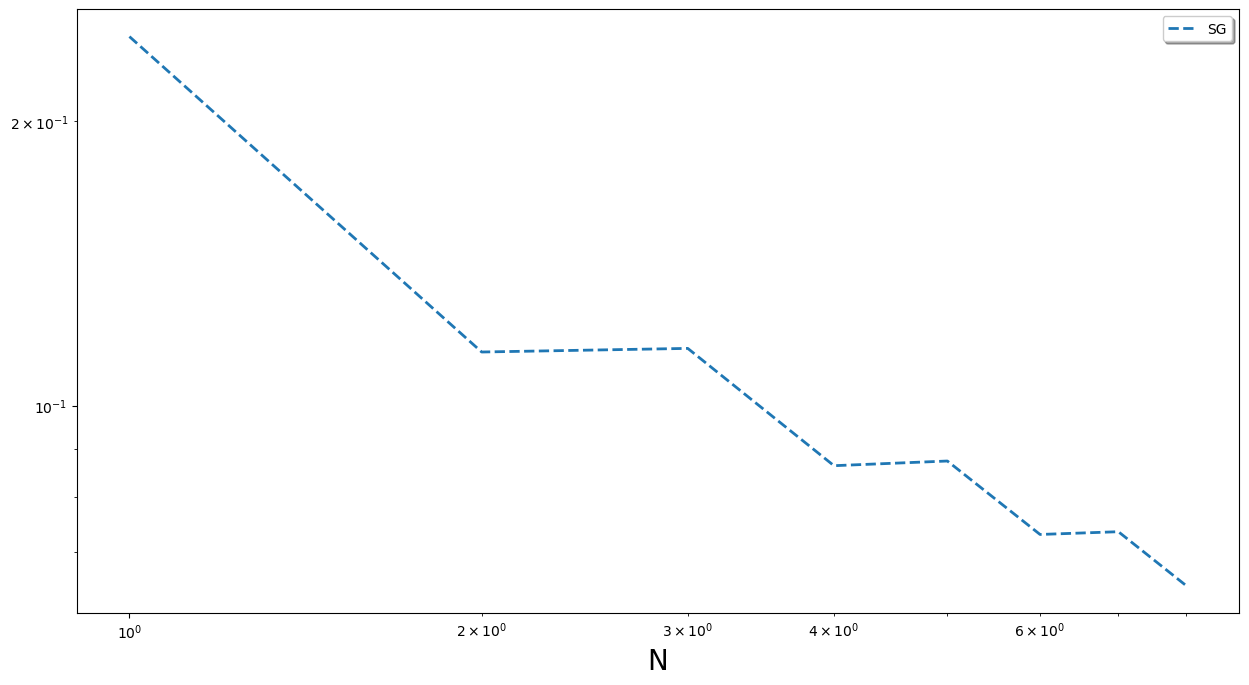

In [10]:
def L2ErrorFull(uHat,x,tEnd,N,Nx):
    Nq = 1000;
    
    y,w = np.polynomial.legendre.leggauss(Nq)
    #w=w/sum(w)
    PhiQuad = np.zeros((Nq,N))
    for i in range(N):
        for k in range(Nq):
            n = i
            PhiQuad[k,i] = np.sqrt(2.0*n+1.0)*mylegendre(n,y[k])
    
    dx = x[2]-x[1];
    tmp = 0;
    for j in range(1,(Nx-1)):
        uQ = np.dot(PhiQuad,uHat[j,:])
        for k in range(Nq):
            tmp = tmp + 0.5*dx*w[k]*(uQ[k] - uExactScalar(tEnd,x[j],y[k]))**2      
    return np.sqrt(tmp)


# dimension of uncertain dimension
dim = 1
# number of spatial cells
Nx = 1000
# spatial domain ranges
if problem == "nonsmooth":
    a = -1.0
    b = 1.0
else:
    a = 0.0
    b = 2*np.pi
# end time
tEnd = 0.3

x = np.linspace(a,b,Nx-2); # vector of cell midpoints
dx = x[1]-x[0];
x = np.hstack((x[0]-dx,x,x[-1]+dx)); # add ghost cells

uRef = uExpExact(tEnd,x)

###### Stochastic Galerkin ######
# number of moments
N = np.arange(1,9)
error = np.zeros((N.size,))
for i in range(N.size):
    uSG = StochasticGalerkin(N[i],Nx,tEnd,a,b)
    error[i] = L2ErrorFull(uSG,x,tEnd,N[i],Nx);
    print("{0}  {1}".format(N[i],error[i]))

###### plotting ######
plt.figure(figsize=(15, 8), dpi=100)
plt.loglog(N,error, linestyle="--", linewidth=2, label="SG", alpha=1.0)
#plt.loglog(level,errorSC, linestyle="dotted", linewidth=2, label="SC", alpha=1.0)
#plt.xlim([a,b])
plt.xlabel("N", fontsize=20);
_=plt.legend(shadow=True, fancybox=True)